# Bert NER using BIO format
This notebook follows the tutorial: https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/?fbclid=IwAR0jI8JgegMSVJ_5k2i4hzlyedLxmR0UuPzjfK8LavaO7z3yUqNRRJiJsr4


##Installing dependencies

In [0]:
!pip install transformers==2.6.0
!pip install seqeval

     |████████████████████████████████| 542kB 8.3MB/s 
     |████████████████████████████████| 1.1MB 22.3MB/s 
     |████████████████████████████████| 890kB 43.9MB/s 
     |████████████████████████████████| 3.7MB 55.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=bc277bad1bbf82c44297c089a5e18aeababfbdfeb45ed862bd44ba22fbba66d0
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=44ff5e19ac3bac6b677f56b7a1872c0ab89c28e962e81ac73fac46631d26c441
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from seqeval.metrics import f1_score

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report


import seaborn as sns

import itertools
import re

import pandas as pd
import numpy as np
from tqdm import tqdm, trange

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

import transformers
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup

transformers.__version__


MAX_LEN = 75
bs = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

torch.cuda.get_device_name(0) 



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


'Tesla P100-PCIE-16GB'

## Utility Functions

In [0]:

def transform_label(l): 
    return re.sub(r'^([BI]).*',r'\1-FOOD',l)
    

def get_label(l):
  return l

In [0]:


class SentenceGetter(object):
    
    def __init__(self, data, column, label_adapter=get_label):
        self.n_sent = 1
        self.data = data
        self.empty = False

        self.grouped=[]
        sentence=[]
        for key,value in zip(data[column].keys(), data[column].values):
          
          sentence.append((key,label_adapter(value)))
          if key is '.':
            self.grouped.append(sentence)
            sentence=[]
        
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [0]:


def get_label_indices(train_data, test_data, label_adapter):
  all_labels=[label_adapter(l) for l in itertools.chain(train_data[train_header].values, test_data[test_header].values)]
  tag_values = list(set([label_adapter(l) for l in all_labels]))
  tag_values.append("PAD")
  tag2idx = {t: i for i, t in enumerate(tag_values)}
  return tag_values, tag2idx

In [0]:
def process_bio(data, column, label_adapter):
  getter = SentenceGetter(data, column, label_adapter)

  sentences = [[word[0] for word in sentence] for sentence in getter.sentences]


  tag_values = list(set([label_adapter(l) for l in data[column].values]))
  tag_values.append("PAD")
  tag2idx = {t: i for i, t in enumerate(tag_values)}

  labels = [[s[1] for s in sentence] for sentence in getter.sentences]

  return getter, sentences, tag_values, tag2idx, labels

In [0]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [0]:


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


##Initializing torch

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)


In [0]:

ds_tag_values = {
    'food-classification': ['B-FOOD', 'I-FOOD', 'O', 'PAD'],
    "hansard-closest": ['B-AG.01.h.01.f', 'I-AG.01.f', 'B-AG.01.h.02.d', 'B-AF.02.a', 'B-AG.01.ae.03', 'I-AG.01.z',
                        'I-AG.01.n.12', 'I-AG.01.n.15', 'I-AG.01.m', 'B-AG.01.f', 'I-AG.01.n.02', 'I-AG.01.ad',
                        'B-AG.01.n.02', 'I-AF.10.i', 'I-AG.01.d.02', 'B-AG.01.d.03', 'B-AF.20.h', 'I-AG.01.t.07',
                        'I-AG.01.t.08', 'I-AG.01.d.05', 'B-AG.01.ad', 'B-AF.10.i', 'I-AG.01.h.02.e', 'I-AG.01.h.01',
                        'B-AG.01.l.04', 'B-AG.01.t.08', 'B-AG.01.j', 'I-AG.01.h.02.i', 'B-AG.01.ae.01',
                        'I-AG.01.h.02.b', 'B-AG.01', 'B-AG.01.h.02.c', 'I-AG.01.n.06', 'I-AG.01.k', 'I-AG.01.n',
                        'B-AG.01.y.01.b', 'I-AG.01.p', 'B-AG.01.l.03', 'I-AG.01.d.06', 'I-AG.01.n.14', 'I-AG.01.d.07',
                        'B-AG.01.d.06', 'B-AF.20.e', 'I-AG.01.l.04', 'B-AF.12', 'I-AG.01.l', 'I-AG.01.l.01',
                        'B-AG.01.h.01.c', 'I-AG.01.y.01.g', 'I-AG.01.h.02.f', 'B-AF.20.c', 'I-AG.01.ae.03',
                        'I-AG.01.n.11', 'B-AG.01.h.01.d', 'B-AG.01.l.02', 'I-AG.01.e.01', 'B-AG.01.k', 'I-AG.01.n.09',
                        'I-AG.01.ae.01', 'B-AE.10', 'B-AG.01.o', 'I-AG.01.h.02.c', 'B-AF.13', 'B-AG.01.h.01.b',
                        'B-AG.01.h.02.f', 'I-AG.01.h.02.h', 'I-AG.01.n.04', 'I-AG.01.ab', 'I-AG.01.ag', 'B-AG.01.t.07',
                        'B-AG.01.n.17.a', 'I-AG.01.e.02', 'I-AG.01.h.01.b', 'B-AG.01.h', 'B-AG.01.n.12', 'B-AG.01.l.01',
                        'B-AG.01.y.01.g', 'B-AG.01.n.03', 'I-AG.01.l.02', 'I-AG.01.j', 'I-AG.01.n.17.a',
                        'B-AG.01.h.02.a', 'B-AG.01.n.04', 'B-AG.01.m', 'B-AG.01.h.02.h', 'I-AG.01.y.01.a', 'B-AG.01.ac',
                        'B-AG.01.n.13', 'B-AF.28', 'B-AG.01.g', 'B-AG.01.n.01', 'B-AE.08.i', 'B-AG.01.h.02.b',
                        'B-AG.01.ab', 'I-AG.01.h.02.a', 'I-AG.01.g', 'I-AG.01.h.01.a', 'I-AG.01.n.01', 'B-AG.01.h.02.i',
                        'I-AF.02.a', 'I-AG.01.h', 'B-AE.13.h.01', 'B-AG.01.h.02.g', 'I-AG.01.ac', 'I-AG.01.h.01.e',
                        'I-AG.01.n.13', 'B-AG.01.e', 'I-AG.01.h.01.c', 'B-AG.01.d.07', 'B-AG.01.n.09', 'I-AG.01.n.03',
                        'B-AE.10.g', 'I-AG.01.d.03', 'B-AG.01.h.01.e', 'B-AG.01.h.01', 'B-AG.01.y.01.f', 'B-AG.01.n.06',
                        'O', 'I-AF.20.g', 'B-AG.01.y.01', 'B-AG.01.n.11', 'I-AG.01.h.01.f', 'I-AG.01.y.01', 'B-AG.01.l',
                        'B-AG.01.n.05', 'B-AG.01.y.01.a', 'B-AG.01.h.01.a', 'B-AG.01.e.01', 'B-AG.01.i', 'B-AG.01.n.14',
                        'I-AG.01.h.02', 'B-AG.01.h.02.e', 'B-AG.01.n.15', 'B-AG.01.d.02', 'I-AG.01.n.05', 'I-AG.01.e',
                        'B-AF.20.g', 'I-AG.01.h.02.g', 'B-AG.01.h.02', 'I-AG.01', 'B-AG.01.p', 'I-AG.01.y.01.c',
                        'B-AG.01.n.16', 'I-AG.01.t.05', 'I-AG.01.l.03', 'B-AG.01.y.01.c', 'B-AG.01.t.05', 'B-AG.01.z',
                        'B-AG.01.n', 'B-AG.01.e.02', 'B-AG.01.d.05', 'I-AG.01.i', 'B-AG.01.ag', 'I-AG.01.o', 'PAD'],
    "hansard-parent": ['B-AG.01.r', 'I-AF.12', 'I-AG.01.f', 'B-AE.11', 'I-AG.01.z', 'I-AG.01.d', 'I-AG.01.m',
                       'B-AG.01.f', 'B-AE.13', 'I-AG.01.ad', 'B-AG.01.y', 'I-AG.01.y', 'B-AG.01.a', 'B-AG.01.ad',
                       'B-AF.23', 'B-AG.01.ae', 'B-AE.07', 'B-AG.01.j', 'B-AF.02', 'I-AF.13', 'B-AG.01.ah', 'B-AG.01',
                       'I-AG.01.k', 'I-AG.01.ah', 'I-AG.01.n', 'B-AE.14', 'B-AF.10', 'B-AF.12', 'I-AF.26', 'I-AG.01.l',
                       'B-AG.01.aa', 'B-AG.01.k', 'B-AE.10', 'B-AG.01.o', 'B-AF.13', 'B-AG.01.aj', 'B-AG.01.t',
                       'I-AG.01.ab', 'I-AG.01.ag', 'B-AG.01.af', 'I-AF.11', 'B-AF.29', 'B-AG.01.h', 'I-AG.01.j',
                       'I-AF.02', 'B-AG.01.m', 'B-AG.01.ac', 'I-AF.23', 'I-AE.08', 'B-AF.28', 'B-AG.01.g', 'B-AF.19',
                       'B-AF.11', 'B-AG.01.ab', 'I-AF.19', 'B-AG.01.d', 'I-AG.01.g', 'I-AG.01.h', 'B-AG.01.b',
                       'I-AG.01.ac', 'B-AG.01.e', 'I-AF.24', 'I-AG.01.a', 'I-AE.14', 'O', 'I-AG.01.ae', 'B-AG.01.l',
                       'I-AAG.01.m', 'B-AF.20', 'B-AAG.01.m', 'I-AF.28', 'B-AG.01.i', 'I-AE.13', 'I-AF.29', 'I-AG.01.t',
                       'I-AG.01.e', 'B-AF.26', 'I-AG.01', 'I-AG.01.aa', 'I-AE.11', 'I-AG.01.aj', 'I-AF.10', 'I-AG.01.r',
                       'I-AG.01.af', 'I-AF.20', 'B-AG.01.n', 'B-AG.01.z', 'B-AF.24', 'I-AG.01.i', 'B-AG.01.ak',
                       'B-AE.08', 'B-AG.01.ag', 'I-AG.01.o', 'PAD'],
    "foodon": ['I-FOODON_03309457', 'I-FOODON_03306867', 'B-FOODON_03316284', 'I-FOODON_03301585', 'I-FOODON_03304042',
               'B-NCBITaxon_381124', 'I-NCBITaxon_4615', 'I-NCBITaxon_89151', 'B-FOODON_03301126', 'I-FOODON_03301441',
               'B-FOODON_03309554', 'I-FOODON_03305086', 'B-FOODON_03302775', 'B-FOODON_03411044', 'B-FOODON_03301630',
               'B-NCBITaxon_9031', 'B-FOODON_03303508', 'I-UBERON_0001913', 'I-NCBITaxon_51238', 'B-FOODON_03306347',
               'B-FOODON_03420108', 'B-NCBITaxon_29780', 'I-NCBITaxon_4006', 'B-FOODON_03302946', 'I-FOODON_03309462',
               'B-NCBITaxon_80379', 'I-NCBITaxon_4113', 'B-FOODON_03430137', 'I-FOODON_03315647', 'B-FOODON_03301128',
               'B-FOODON_03315498', 'B-FOODON_03305639', 'B-FOODON_03315025', 'I-FOODON_03315258', 'I-FOODON_03310086',
               'B-FOODON_03301844', 'B-NCBITaxon_13450', 'I-NCBITaxon_3747', 'B-FOODON_03315647', 'I-FOODON_03310689',
               'I-hancestro_0383', 'I-FOODON_03301605', 'B-FOODON_03315597', 'B-FOODON_03309491', 'I-NCBITaxon_4329',
               'I-FOODON_03301710', 'B-NCBITaxon_4006', 'B-FOODON_03411269', 'I-FOODON_03302897', 'B-FOODON_03306867',
               'B-FOODON_03307062', 'B-NCBITaxon_3755', 'I-NCBITaxon_3755', 'B-FOODON_03315872', 'B-CHEBI_83163',
               'B-FOODON_03309457', 'B-FOODON_03303886', 'B-FOODON_03301710', 'B-ancestro_0354', 'I-FOODON_03305417',
               'B-FOODON_03310795', 'I-FOODON_03430168', 'B-FOODON_03301455', 'B-FOODON_03302904', 'I-FOODON_03306766',
               'B-FOODON_03304564', 'B-FOODON_03317068', 'B-FOODON_03301217', 'I-FOODON_03301217', 'B-FOODON_03316070',
               'I-FOODON_03309832', 'B-FOODON_03301329', 'B-FOODON_03301105', 'I-FOODON_03315872', 'B-FOODON_03301705',
               'B-FOODON_03304010', 'B-FOODON_03305263', 'B-FOODON_03305680', 'B-FOODON_03310185', 'B-GAZ_00000558',
               'B-FOODON_03310290', 'I-FOODON_03305954', 'B-FOODON_03305518', 'I-NCBITaxon_4039', 'B-UBERON_0036016',
               'I-FOODON_03311146', 'B-NCBITaxon_4615', 'I-FOODON_03302908', 'I-FOODON_03302515', 'I-FOODON_03301889',
               'I-FOODON_03306160', 'I-FOODON_03310351', 'B-FOODON_03301842', 'B-FOODON_03301672', 'I-NCBITaxon_4565',
               'I-PO_0009001', 'B-FOODON_03315188', 'I-FOODON_03301329', 'B-PATO_0000386', 'B-NCBITaxon_94328',
               'B-FOODON_03302772', 'B-FOODON_03315835', 'B-FOODON_03305954', 'B-FOODON_03301660', 'B-FOODON_03303578',
               'B-NCBITaxon_4081', 'B-NCBITaxon_37656', 'I-FOODON_03316347', 'B-FOODON_03301441', 'I-FOODON_03301304',
               'B-FOODON_03317034', 'B-FOODON_03315258', 'B-FOODON_03305236', 'B-FOODON_03301614', 'B-NCBITaxon_32201',
               'I-FOODON_03301505', 'B-NCBITaxon_16718', 'I-FOODON_03301051', 'B-FOODON_03305617', 'B-FOODON_03301304',
               'B-UBERON_0001913', 'B-NCBITaxon_4530', 'I-FOODON_03411335', 'I-FOODON_03301455', 'I-ancestro_0354',
               'B-FOODON_03315259', 'I-PATO_0000386', 'B-NCBITaxon_23211', 'I-FOODON_03315597', 'I-FOODON_03301008',
               'I-FOODON_03302062', 'I-FOODON_03302946', 'B-FOODON_03301175', 'B-FOODON_03302060', 'I-GAZ_00000558',
               'I-NCBITaxon_59895', 'B-FOODON_03307808', 'I-FOODON_03301660', 'B-NCBITaxon_3493', 'B-FOODON_03305417',
               'I-FOODON_03305680', 'I-CHEBI_60004', 'I-FOODON_03530021', 'I-FOODON_03305428', 'B-NCBITaxon_3562',
               'I-FOODON_03411669', 'B-FOODON_03316042', 'B-FOODON_03307280', 'I-FOODON_03420108', 'I-NCBITaxon_3827',
               'I-FOODON_03302060', 'B-FOODON_03305003', 'I-NCBITaxon_4530', 'I-FOODON_03301116', 'B-CHEBI_60004',
               'I-FOODON_03301672', 'B-FOODON_03301619', 'I-NCBITaxon_80379', 'I-FOODON_03302904', 'B-FOODON_03315146',
               'I-FOODON_03301705', 'B-FOODON_03305428', 'I-FOODON_03302034', 'B-FOODON_03302034', 'B-FOODON_03302515',
               'I-FOODON_03301072', 'B-CHEBI_24866', 'I-NCBITaxon_3562', 'I-FOODON_03301701', 'B-FOODON_03301051',
               'I-FOODON_03303578', 'B-FOODON_03301505', 'I-FOODON_03305617', 'I-FOODON_03307062', 'B-NCBITaxon_89151',
               'I-NCBITaxon_37656', 'B-NCBITaxon_4071', 'I-ENVO_01001125', 'B-FOODON_03302908', 'B-FOODON_03306160',
               'B-FOODON_03304042', 'B-FOODON_03317294', 'I-FOODON_03315498', 'B-FOODON_03310760', 'B-NCBITaxon_51238',
               'B-NCBITaxon_59895', 'B-FOODON_03311146', 'B-FOODON_03301605', 'B-FOODON_03301008', 'I-FOODON_03304010',
               'B-NCBITaxon_39352', 'I-FOODON_03411044', 'I-FOODON_03307668', 'I-NCBITaxon_381124', 'I-NCBITaxon_34199',
               'I-FOODON_03304564', 'B-FOODON_03411328', 'B-NCBITaxon_3747', 'B-FOODON_03301889', 'I-FOODON_03411328',
               'I-NCBITaxon_3760', 'B-FOODON_03310387', 'B-FOODON_03303659', 'B-FOODON_03530021', 'I-FOODON_03315272',
               'I-FOODON_03301844', 'B-NCBITaxon_3649', 'B-FOODON_03310086', 'B-FOODON_03411237', 'B-FOODON_03307240',
               'B-NCBITaxon_117781', 'I-CHEBI_24866', 'B-FOODON_03411335', 'I-FOODON_03303886', 'B-FOODON_03306766',
               'B-FOODON_03303225', 'I-FOODON_03307280', 'B-FOODON_03302897', 'O', 'B-FOODON_03302062',
               'B-NCBITaxon_34199', 'B-NCBITaxon_3760', 'I-FOODON_03303380', 'B-FOODON_03430168', 'B-CHEBI_33290',
               'B-FOODON_03301072', 'I-NCBITaxon_3888', 'B-ENVO_00002006', 'B-NCBITaxon_3888', 'I-FOODON_03316042',
               'B-NCBITaxon_4565', 'B-FOODON_00001287', 'I-FOODON_03305263', 'I-FOODON_03317068', 'B-NCBITaxon_63459',
               'I-FOODON_03310795', 'I-FOODON_00001287', 'I-FOODON_03317294', 'B-FOODON_03301397', 'I-FOODON_03420157',
               'B-FOODON_03301802', 'B-FOODON_03316347', 'I-NCBITaxon_4081', 'I-FOODON_03303508', 'B-FOODON_03315272',
               'I-FOODON_03301614', 'B-FOODON_03301240', 'I-FOODON_03305003', 'B-FOODON_03411669', 'B-FOODON_03301585',
               'B-FOODON_03310272', 'B-FOODON_03309462', 'B-FOODON_03304704', 'I-FOODON_03301842', 'B-FOODON_03302835',
               'B-ENVO_01001125', 'B-FOODON_03305086', 'I-FOODON_03309554', 'I-FOODON_03310387', 'B-FOODON_03302458',
               'I-FOODON_03302772', 'I-FOODON_03315835', 'B-NCBITaxon_4682', 'I-FOODON_03303659', 'I-FOODON_03301128',
               'B-FOODON_03412974', 'I-FOODON_03310272', 'B-FOODON_03303380', 'B-FOODON_03307663', 'I-NCBITaxon_4682',
               'B-FOODON_03309832', 'B-FOODON_03301189', 'B-PO_0009001', 'B-FOODON_03310351', 'B-NCBITaxon_39350',
               'I-FOODON_03302458', 'B-NCBITaxon_49992', 'B-UBERON_0007378', 'I-UBERON_0007378', 'B-FOODON_03301701',
               'B-FOODON_03310689', 'I-FOODON_03302835', 'I-ENVO_00002006', 'B-hancestro_0383', 'B-FOODON_03307668',
               'B-FOODON_03301116', 'I-NCBITaxon_9031', 'I-FOODON_03430137', 'B-FOODON_03301440', 'B-FOODON_03420157',
               'I-FOODON_03315188', 'I-NCBITaxon_4071', 'B-NCBITaxon_4039', 'B-NCBITaxon_6563', 'B-NCBITaxon_4113',
               'B-NCBITaxon_3827', 'I-FOODON_03307240', 'B-NCBITaxon_4329', 'I-FOODON_03303225', 'B-FOODON_03306616',
               'PAD'],
    "snomedct": ['B-443701000124100', 'B-226719003', 'B-227215000', 'B-735050002', 'B-391858005', 'B-67324005',
                 'B-229862008', 'B-16313001', 'I-70813002', 'B-226942002', 'I-227553009', 'I-412061001', 'B-226890008',
                 'I-256326004', 'B-736159005', 'B-226888007', 'I-226831005', 'B-227444000', 'B-230053007', 'B-28647000',
                 'B-442341000124109', 'B-227411006', 'I-256307007', 'B-735030001', 'I-226647005', 'B-22836000',
                 'I-226543002', 'B-256307007', 'B-227430006', 'I-713648000', 'I-255621006', 'I-227436000',
                 'B-420823005', 'B-713648000', 'B-102261002', 'I-227501001', 'B-226483007', 'I-735053000',
                 'B-608772009', 'I-227020009', 'B-256313003', 'B-129559002', 'I-256313003', 'B-444001000124100',
                 'B-227282006', 'I-412070003', 'B-229937009', 'I-227545001', 'B-226733003', 'B-230055000',
                 'I-226551004', 'B-226054000', 'I-256442007', 'I-28647000', 'I-412357001', 'B-227219006', 'B-735108004',
                 'B-412061001', 'B-735213008', 'B-226814003', 'B-328685004', 'I-444021000124105', 'B-226723006',
                 'I-901000161107', 'I-230055000', 'B-229948002', 'B-227449005', 'B-51905005', 'B-226787009',
                 'I-22836000', 'B-227020009', 'B-734881000', 'B-412357001', 'B-442681000124105', 'B-226031009',
                 'B-412071004', 'I-226837009', 'I-442681000124105', 'B-63766005', 'I-227215000', 'B-735336002',
                 'B-227260004', 'I-102261002', 'I-227260004', 'I-734881000', 'I-226814003', 'B-735245003',
                 'B-256329006', 'I-735030001', 'I-227219006', 'I-391858005', 'B-226725004', 'B-23182003', 'B-226551004',
                 'I-226054000', 'I-226888007', 'B-226726003', 'B-735211005', 'I-443981000124106', 'I-735211005',
                 'I-735214002', 'B-227519005', 'I-735248001', 'I-226890008', 'B-227722009', 'B-735047000',
                 'I-227592002', 'B-227436000', 'I-229944000', 'B-226604005', 'B-226955001', 'I-102264005',
                 'I-226802006', 'B-256326004', 'B-227423000', 'I-226496008', 'B-227365007', 'B-229887001', 'B-89707004',
                 'B-901000161107', 'B-227425007', 'I-735340006', 'B-13577000', 'B-227757007', 'B-735340006',
                 'I-412071004', 'I-412066006', 'B-226749001', 'B-227410007', 'B-442891000124107', 'B-256442007',
                 'I-226493000', 'B-735040003', 'I-89707004', 'B-226559002', 'B-72511004', 'I-735047000', 'I-230053007',
                 'B-419420009', 'I-63766005', 'I-227388008', 'I-226928005', 'B-278840001', 'B-29263009', 'B-226740002',
                 'B-226493000', 'I-442341000124109', 'I-9424004', 'B-227463004', 'B-226064009', 'B-227549007',
                 'I-328685004', 'I-444001000124100', 'B-226802006', 'I-256443002', 'B-226831005', 'B-226587006',
                 'B-735123009', 'B-735214002', 'B-227566009', 'B-226928005', 'I-227757007', 'B-442751000124107',
                 'B-226639005', 'B-227592002', 'B-227400003', 'B-41834005', 'I-226934003', 'B-444021000124105',
                 'B-735010000', 'I-227607007', 'B-260184002', 'B-226916002', 'B-102264005', 'I-227722009',
                 'B-735009005', 'B-226934003', 'B-226901000', 'I-226853007', 'I-227430006', 'B-227545001',
                 'B-608773004', 'B-735215001', 'B-226562004', 'B-226849005', 'B-256443002', 'B-227239005',
                 'B-227612008', 'I-226726003', 'B-227553009', 'I-443701000124100', 'I-229862008', 'B-735042006',
                 'B-735053000', 'I-226838004', 'I-227449005', 'I-735215001', 'I-735245003', 'B-735212003',
                 'I-229937009', 'B-226038003', 'I-256354006', 'I-736159005', 'I-226942002', 'B-226704004',
                 'I-227395004', 'B-227390009', 'I-226855000', 'B-9424004', 'I-226849005', 'B-443691000124100',
                 'I-227612008', 'B-735249009', 'B-443981000124106', 'O', 'B-229944000', 'I-227282006', 'B-35748005',
                 'I-256350002', 'B-227418000', 'I-129559002', 'I-226955001', 'B-227689008', 'I-226559002',
                 'B-227407000', 'B-227388008', 'B-256354006', 'I-41834005', 'I-443691000124100', 'B-227382009',
                 'B-442861000124104', 'B-226769006', 'B-226838004', 'I-227519005', 'B-735048005', 'B-226735005',
                 'I-226916002', 'I-226787009', 'B-226041007', 'I-260184002', 'B-735248001', 'B-227515004',
                 'B-229908005', 'B-227421003', 'I-16313001', 'B-226753004', 'B-227408005', 'B-226855000', 'B-226018004',
                 'B-256350002', 'I-35748005', 'I-226639005', 'B-444161000124100', 'B-226496008', 'I-29263009',
                 'B-442361000124108', 'B-227606003', 'B-70813002', 'B-226528004', 'I-735045008', 'B-227218003',
                 'I-735049002', 'B-227607007', 'I-226041007', 'I-102262009', 'I-442361000124108', 'B-226543002',
                 'B-53410008', 'B-255621006', 'I-226749001', 'I-735042006', 'B-735049002', 'B-227413009', 'B-226863004',
                 'I-256329006', 'B-412062008', 'I-226753004', 'B-227501001', 'B-735106000', 'B-227395004',
                 'B-226853007', 'I-226038003', 'B-256317002', 'B-226647005', 'B-735045008', 'B-442811000124102',
                 'B-412070003', 'B-226837009', 'B-442581000124106', 'B-736031006', 'B-102262009', 'B-227598003',
                 'B-412066006', 'B-226057007', 'PAD']
}

## Parameters


loading...
bioBert-large-model-hansard-parent-e10


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Average train loss: 0.21086657279223767


Epoch:  10%|█         | 1/10 [05:16<47:24, 316.05s/it]

Validation loss: 0.062266579208274685
Validation Accuracy: 0.9819270833333333
Validation F1-Score: 0.7340675212132154

Average train loss: 0.04753717807789316


Epoch:  20%|██        | 2/10 [10:30<42:05, 315.66s/it]

Validation loss: 0.03590586921200156
Validation Accuracy: 0.9918923611111109
Validation F1-Score: 0.8886418380581805

Average train loss: 0.027592407317638817


Epoch:  30%|███       | 3/10 [15:45<36:47, 315.33s/it]

Validation loss: 0.03011472406797111
Validation Accuracy: 0.9930729166666666
Validation F1-Score: 0.9071627906976744

Average train loss: 0.019290461269743247


Epoch:  40%|████      | 4/10 [20:59<31:30, 315.01s/it]

Validation loss: 0.03188174881506711
Validation Accuracy: 0.9932291666666666
Validation F1-Score: 0.9145394006659268

Average train loss: 0.01449608268163536


Epoch:  50%|█████     | 5/10 [26:13<26:14, 314.81s/it]

Validation loss: 0.031212787182691198
Validation Accuracy: 0.9936805555555557
Validation F1-Score: 0.9203933939506401

Average train loss: 0.010814562763904556


Epoch:  60%|██████    | 6/10 [31:28<20:58, 314.67s/it]

Validation loss: 0.03067892025380085
Validation Accuracy: 0.9936458333333337
Validation F1-Score: 0.9193308550185874

Average train loss: 0.008031514085299897


Epoch:  70%|███████   | 7/10 [36:42<15:43, 314.57s/it]

Validation loss: 0.033342110264735915
Validation Accuracy: 0.9937847222222222
Validation F1-Score: 0.9206467199405314

Average train loss: 0.0063797268513502235


Epoch:  80%|████████  | 8/10 [41:57<10:29, 314.55s/it]

Validation loss: 0.033416550179633
Validation Accuracy: 0.9940277777777777
Validation F1-Score: 0.9265747297800969

Average train loss: 0.005097192431797871


Epoch:  90%|█████████ | 9/10 [47:11<05:14, 314.47s/it]

Validation loss: 0.03382427990436554
Validation Accuracy: 0.9941145833333332
Validation F1-Score: 0.9260845280208528

Average train loss: 0.004070428359862593


Epoch: 100%|██████████| 10/10 [52:25<00:00, 314.55s/it]

Validation loss: 0.03435455025949826
Validation Accuracy: 0.9942361111111112
Validation F1-Score: 0.9279463787004284




/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



loading...
bioBert-large-model-hansard-closest-e10


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Average train loss: 0.2592319892398242


Epoch:  10%|█         | 1/10 [03:35<32:19, 215.54s/it]

Validation loss: 0.08883294764467899
Validation Accuracy: 0.9822794117647061
Validation F1-Score: 0.6242269916333211

Average train loss: 0.0644754323080696


Epoch:  20%|██        | 2/10 [07:10<28:42, 215.25s/it]

Validation loss: 0.03388717244653141
Validation Accuracy: 0.9921813725490196
Validation F1-Score: 0.8342022940563086

Average train loss: 0.030613818909202156


Epoch:  30%|███       | 3/10 [10:44<25:05, 215.11s/it]

Validation loss: 0.025550713324371505
Validation Accuracy: 0.9940441176470588
Validation F1-Score: 0.9052183173588926

Average train loss: 0.018615915244124058


Epoch:  40%|████      | 4/10 [14:19<21:30, 215.03s/it]

Validation loss: 0.01719680451274411
Validation Accuracy: 0.9965931372549022
Validation F1-Score: 0.9475600873998543

Average train loss: 0.012032991212567892


Epoch:  50%|█████     | 5/10 [17:54<17:54, 214.87s/it]

Validation loss: 0.01433849718031364
Validation Accuracy: 0.9968137254901963
Validation F1-Score: 0.9522098454904778

Average train loss: 0.008580123051872541


Epoch:  60%|██████    | 6/10 [21:28<14:19, 214.80s/it]

Validation loss: 0.013037367788509821
Validation Accuracy: 0.9972058823529412
Validation F1-Score: 0.9602007888131947

Average train loss: 0.006263546471018344


Epoch:  70%|███████   | 7/10 [25:03<10:44, 214.75s/it]

Validation loss: 0.011678980110873989
Validation Accuracy: 0.9974754901960786
Validation F1-Score: 0.9646974063400576

Average train loss: 0.005024495105467865


Epoch:  80%|████████  | 8/10 [28:37<07:09, 214.63s/it]

Validation loss: 0.011520382651189506
Validation Accuracy: 0.9975980392156863
Validation F1-Score: 0.9681851048445408

Average train loss: 0.004361257841810584


Epoch:  90%|█████████ | 9/10 [32:12<03:34, 214.66s/it]

Validation loss: 0.0111346169918868
Validation Accuracy: 0.997549019607843
Validation F1-Score: 0.963708228530363

Average train loss: 0.0037374159435597087


Epoch: 100%|██████████| 10/10 [35:46<00:00, 214.69s/it]

Validation loss: 0.010999200899438137
Validation Accuracy: 0.9976225490196079
Validation F1-Score: 0.9654676258992806




loading...
bioBert-large-model-foodon-e10


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Average train loss: 0.2840137624791984


Epoch:  10%|█         | 1/10 [03:35<32:18, 215.39s/it]

Validation loss: 0.13327889451209238
Validation Accuracy: 0.9800735294117648
Validation F1-Score: 0.6218181818181818

Average train loss: 0.12046127668742476


Epoch:  20%|██        | 2/10 [07:10<28:42, 215.32s/it]

Validation loss: 0.09413082568961031
Validation Accuracy: 0.984485294117647
Validation F1-Score: 0.659908768373036

Average train loss: 0.07521423992925677


Epoch:  30%|███       | 3/10 [10:45<25:06, 215.25s/it]

Validation loss: 0.044612636680112165
Validation Accuracy: 0.991544117647059
Validation F1-Score: 0.7803193785066898

Average train loss: 0.04188489494524125


Epoch:  40%|████      | 4/10 [14:20<21:31, 215.19s/it]

Validation loss: 0.031458718154360264
Validation Accuracy: 0.9927450980392158
Validation F1-Score: 0.8360375747224594

Average train loss: 0.027658837587283602


Epoch:  50%|█████     | 5/10 [17:55<17:55, 215.04s/it]

Validation loss: 0.02487463279206114
Validation Accuracy: 0.9946323529411764
Validation F1-Score: 0.8721227621483377

Average train loss: 0.02042021507333065


Epoch:  60%|██████    | 6/10 [21:29<14:19, 214.87s/it]

Validation loss: 0.02129970038710299
Validation Accuracy: 0.9958823529411764
Validation F1-Score: 0.9035884133160398

Average train loss: 0.015503468785178045


Epoch:  70%|███████   | 7/10 [25:04<10:44, 214.84s/it]

Validation loss: 0.019768130172023494
Validation Accuracy: 0.9966666666666668
Validation F1-Score: 0.9276116168183788

Average train loss: 0.012492780447014254


Epoch:  80%|████████  | 8/10 [28:39<07:09, 214.81s/it]

Validation loss: 0.019950868007607127
Validation Accuracy: 0.996642156862745
Validation F1-Score: 0.9355961705831157

Average train loss: 0.01091787779687679


Epoch:  90%|█████████ | 9/10 [32:13<03:34, 214.74s/it]

Validation loss: 0.01960374870866551
Validation Accuracy: 0.9968872549019607
Validation F1-Score: 0.9439579684763573

Average train loss: 0.009963684090702184


Epoch: 100%|██████████| 10/10 [35:48<00:00, 214.87s/it]

Validation loss: 0.019449904207516844
Validation Accuracy: 0.9968382352941176
Validation F1-Score: 0.9393278044522043




loading...
bioBert-large-model-snomedct-e10


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Average train loss: 0.3899617106493177


Epoch:  10%|█         | 1/10 [03:35<32:19, 215.46s/it]

Validation loss: 0.12156940098194514
Validation Accuracy: 0.9809313725490199
Validation F1-Score: 0.6221952698605215

Average train loss: 0.0864097043614963


Epoch:  20%|██        | 2/10 [07:10<28:42, 215.28s/it]

Validation loss: 0.05036153139628689
Validation Accuracy: 0.9907598039215687
Validation F1-Score: 0.7735596248325144

Average train loss: 0.04078403140321888


Epoch:  30%|███       | 3/10 [10:45<25:06, 215.15s/it]

Validation loss: 0.03466906466757577
Validation Accuracy: 0.9937990196078431
Validation F1-Score: 0.8481123792800702

Average train loss: 0.025357602755057402


Epoch:  40%|████      | 4/10 [14:19<21:30, 215.02s/it]

Validation loss: 0.02340139221632853
Validation Accuracy: 0.9952450980392156
Validation F1-Score: 0.883061049011178

Average train loss: 0.017614301653771564


Epoch:  50%|█████     | 5/10 [17:54<17:54, 214.97s/it]

Validation loss: 0.019895157399279176
Validation Accuracy: 0.9963970588235294
Validation F1-Score: 0.9149028077753779

Average train loss: 0.012517188680518805


Epoch:  60%|██████    | 6/10 [21:29<14:19, 214.80s/it]

Validation loss: 0.016760978909159722
Validation Accuracy: 0.9971078431372549
Validation F1-Score: 0.9372822299651569

Average train loss: 0.009384174369564601


Epoch:  70%|███████   | 7/10 [25:03<10:44, 214.77s/it]

Validation loss: 0.016661075436465635
Validation Accuracy: 0.9975245098039217
Validation F1-Score: 0.9451994739149496

Average train loss: 0.007579083295121532


Epoch:  80%|████████  | 8/10 [28:38<07:09, 214.66s/it]

Validation loss: 0.015443327003167188
Validation Accuracy: 0.9975490196078433
Validation F1-Score: 0.9501312335958005

Average train loss: 0.006498990212727723


Epoch:  90%|█████████ | 9/10 [32:12<03:34, 214.66s/it]

Validation loss: 0.014642290451079402
Validation Accuracy: 0.997671568627451
Validation F1-Score: 0.9509632224168126

Average train loss: 0.005934786407180644


Epoch: 100%|██████████| 10/10 [35:47<00:00, 214.76s/it]

Validation loss: 0.014709935947180116
Validation Accuracy: 0.9977696078431372
Validation F1-Score: 0.9556433904259991



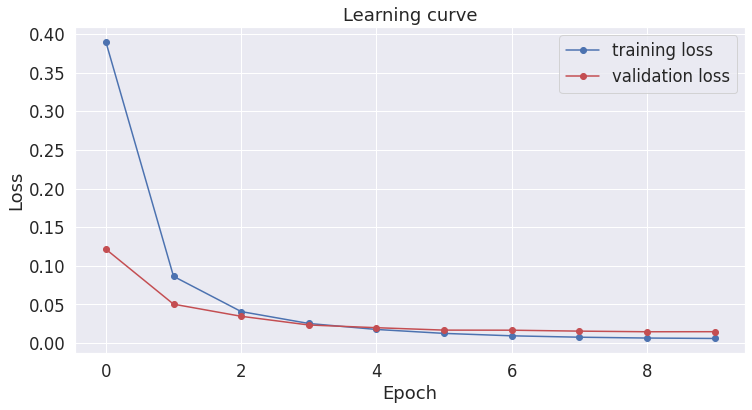

In [0]:
datasets={
  # 'food-classification':'f',
  'hansard-parent': 'p',
  'hansard-closest':'hansard-closest',
  'foodon': 'foodon',
  'snomedct': 'snomedct'
  #'longest-common-tag-part':'L',
  # 'shortest-tag':'s', 
}

stored_models ={
  # 'bert':'bert-base-cased', 
  # 'bioBert-standard': '/content/drive/My Drive/Colab Notebooks/data/biobert',
  'bioBert-large': '/content/drive/My Drive/Colab Notebooks/data/biobert_large'
}

model_tags = {}


train_header='tag'
test_header='-DOCSTART-'
label_adapter = get_label


epochs = 10
max_grad_norm = 1.0

FULL_FINETUNING = True


for version_descriptive,model_version in datasets.items(): 
  print()


  train_path = '/content/drive/My Drive/Colab Notebooks/data/train-'+model_version+'.txt'

  test_path='/content/drive/My Drive/Colab Notebooks/data/test-'+model_version+'.txt'




  # initialize data
  data = pd.read_csv(train_path, encoding="latin1", delimiter='\t').fillna(method="ffill")
  test_data = pd.read_csv(test_path, encoding="latin1", delimiter='\t').fillna(method="ffill")

  getter, sentences, tag_values, tag2idx, labels = process_bio(data, train_header, label_adapter)

  if ds_tag_values.get(version_descriptive): 
    print('loading...')
    tag_values = ds_tag_values.get(version_descriptive)
    tag2idx = {t: i for i, t in enumerate(tag_values)}
  else:   
    with open(version_descriptive+".txt", 'w') as a: 
      print(str(tag_values))
      a.write(str(tag_values))
      model_tags[version_descriptive] = tag_values

  

  tokenized_texts_and_labels = [
      tokenize_and_preserve_labels(sent, labs)
      for sent, labs in zip(sentences, labels)
  ]

  tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
  labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

  input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                            maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")


  tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                      maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                      dtype="long", truncating="post")

  attention_masks = [[float(i != tag2idx["PAD"]) for i in ii] for ii in input_ids]

  tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags, 
                                                              random_state=2018, test_size=0.1)
  tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                              random_state=2018, test_size=0.1)

  tr_inputs = torch.tensor(tr_inputs)
  val_inputs = torch.tensor(val_inputs)
  tr_tags = torch.tensor(tr_tags)
  val_tags = torch.tensor(val_tags)
  tr_masks = torch.tensor(tr_masks)
  val_masks = torch.tensor(val_masks)


  train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

  valid_data = TensorDataset(val_inputs, val_masks, val_tags)
  valid_sampler = SequentialSampler(valid_data)
  valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)
  for model_prefix, load_model in stored_models.items(): 

    model_name=model_prefix+ '-model-'+version_descriptive+'-e'+str(epochs)
    print(model_name)



    # get the model



    model = BertForTokenClassification.from_pretrained(
          load_model,
          num_labels=len(tag2idx),
          output_attentions = False,
          output_hidden_states = False)

    model.cuda();


    if FULL_FINETUNING:
        param_optimizer = list(model.named_parameters())
        no_decay = ['bias', 'gamma', 'beta']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
            'weight_decay_rate': 0.01},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            'weight_decay_rate': 0.0}
        ]
    else:
        param_optimizer = list(model.classifier.named_parameters()) 
        optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

    optimizer = AdamW(
        optimizer_grouped_parameters,        
        lr=3e-5,
        eps=1e-8
    )



    # Total number of training steps is number of batches * number of epochs.
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=0,
        
        num_training_steps=total_steps
    )

    ## Store the average loss after each epoch so we can plot them.
    loss_values, validation_loss_values = [], []

    for _ in trange(epochs, desc="Epoch"):
        # ========================================
        #               Training
        # ========================================
        # Perform one full pass over the training set.
        
        # Put the model into training mode.
        model.train()
        # Reset the total loss for this epoch.
        total_loss = 0

        # Training loop
        for step, batch in enumerate(train_dataloader):
            # add batch to gpu
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            # Always clear any previously calculated gradients before performing a backward pass.
            model.zero_grad()
            # forward pass
            # This will return the loss (rather than the model output)
            # because we have provided the `labels`.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
            # get the loss
            loss = outputs[0]
            # Perform a backward pass to calculate the gradients.
            loss.backward()
            # track train loss
            total_loss += loss.item()    
            # Clip the norm of the gradient
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
            # update parameters
            optimizer.step()
            # Update the learning rate.
            scheduler.step()
            
        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(train_dataloader)
        print("Average train loss: {}".format(avg_train_loss))
        
        # Store the loss value for plotting the learning curve.
        loss_values.append(avg_train_loss)
        
        
        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.
        
        # Put the model into evaluation mode
        model.eval()
        # Reset the validation loss for this epoch.
        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0
        predictions , true_labels = [], []
        for batch in valid_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            
            # Telling the model not to compute or store gradients,
            # saving memory and speeding up validation
            with torch.no_grad():
                # Forward pass, calculate logit predictions.
                # This will return the logits rather than the loss because we have not provided labels.
                outputs = model(b_input_ids, token_type_ids=None,
                                attention_mask=b_input_mask, labels=b_labels)
            # Move logits and labels to CPU
            logits = outputs[1].detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            
            # Calculate the accuracy for this batch of test sentences.
            eval_loss += outputs[0].mean().item()
            eval_accuracy += flat_accuracy(logits, label_ids)
            predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
            true_labels.append(label_ids)
            
            nb_eval_examples += b_input_ids.size(0)
            nb_eval_steps += 1
        
        eval_loss = eval_loss / nb_eval_steps
        validation_loss_values.append(eval_loss)
        print("Validation loss: {}".format(eval_loss))
        print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
        pred_tags = [tag_values[p_i] for p in predictions for p_i in p]
        valid_tags = [tag_values[l_ii] for l in true_labels for l_i in l for l_ii in l_i]
        print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
        print()


    plt.clf()

    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)

    # Plot the learning curve.
    plt.plot(loss_values, 'b-o', label="training loss")
    plt.plot(validation_loss_values, 'r-o', label="validation loss")

    # Label the plot.
    plt.title("Learning curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.savefig(model_name+'.png', format='png')



    # Evaluation

    train_labels = labels
    getter, sentences, m, n, labels = process_bio(test_data, test_header, label_adapter)

    ix=0
    correct = labels
    predicted = []

    for s in sentences:
      test_sentence = " ".join(s)
      
      tokenized_sentence = tokenizer.encode(test_sentence)
      input_ids = torch.tensor([tokenized_sentence]).cuda()

      
      with torch.no_grad():
          output = model(input_ids)
      label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

      tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
      new_tokens, new_labels = [], []
      for token, label_idx in zip(tokens, label_indices[0]):
          if token.startswith("##"):
              new_tokens[-1] = new_tokens[-1] + token[2:]
          else:
              new_labels.append(tag_values[label_idx])
              new_tokens.append(token)


      pred=[]
      for wi in range(0, len(labels[ix])):
        pred.append(new_labels[wi+1])
        
      
      predicted.append(pred)
      ix+=1

    correct_flat = [item for sublist in correct for item in sublist]
    predicted_flat = [item for sublist in predicted for item in sublist]


    target_names = set([item for item in itertools.chain(correct_flat, predicted_flat)])
    len(target_names)
    with open(model_name+'.log', 'w+') as log: 
      log.write(classification_report(correct_flat, predicted_flat, target_names=target_names))

    torch.save(model.state_dict(), model_name+'.bin')

## Restore model